In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
reponses = db.anon_student_task_responses.find()[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.head())

                        _id               behavioral_traits  bonus  correct  \
0  5a00f1739100de1a390000d0                              []  False     True   
1  5a00f1739100de1a390000d5  [measuring_tools, orange_tick]  False     True   
2  5a00f1739100de1a390000d9                              []  False     True   
3  5a00f1739100de1a390000dc                              []  False     True   
4  5a00f1739100de1a390000df                              []  False     True   

       diff          id  incomplete         lesson  \
0  0.000000  nvrm82_9Yv       False       nline_1b   
1  0.563288  jVG3p9f-20       False       nline_1b   
2  0.601043  _NUUDSBMum       False  equivalence_0   
3  0.686276  B6HmMEMpoL       False  equivalence_0   
4  0.642014  IYWiIP26on       False  equivalence_0   

                                       level_summary  \
0  {'entered': True, 'path': 'nline_1b', 'lm_stat...   
1  {'entered': True, 'path': 'nline_1b', 'lm_stat...   
2  {'subject': 'fractions', 'uni

In [8]:
df2 = df_responses.join(pd.DataFrame(df_responses["student"].to_dict()).T)

In [9]:
df2 = df2.join(pd.DataFrame(df2['level_summary'].to_dict()).T)

In [10]:
df2 = df2.join(pd.DataFrame(df2['problems'].to_dict()).T)

In [11]:
df3  = df2.copy()

In [12]:
## Look act columns
print (df_responses.columns)

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched'],
      dtype='object')


In [13]:
## How many data samples
print (len(df_responses), "Number of entries")

100000 Number of entries


In [14]:
## Make 'description' a feature wih important words mapped

In [15]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong'],
      dtype='object')

In [16]:
df3['percent_correct'] = df3['nright'].astype(float) / df3['ntotal']

In [17]:
df3.iloc[0]

_id                                              5a00f1739100de1a390000d0
behavioral_traits                                                      []
bonus                                                               False
correct                                                              True
diff                                                                    0
id                                                             nvrm82_9Yv
incomplete                                                          False
lesson                                                           nline_1b
level_summary           {'entered': True, 'path': 'nline_1b', 'lm_stat...
problem_set             lessons/fractions/lesson13_1/part_a/media/prob...
problem_set_id                                                 _Pd6uU3viE
problem_set_subspace                                                parta
qual_id                                       _Pd6uU3viE.parta.nvrm82_9Yv
randomly_selected                     

In [18]:
for idx in range(100):
    print ('index"', idx)
    print (df3.iloc[idx]['lesson'])
    print (df3.iloc[idx]['response'])

index" 0
nline_1b
{'fraction_cblock_chains': [{'right': 442, 'sum': {'numerator': 1, 'denominator': 2, '__as3_type': 'Fraction'}, 'pieces': ['1/2'], 'left': 97, 'lcm_sum': {'numerator': 1, 'denominator': 2, '__as3_type': 'Fraction'}}], 'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/dog.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf'}], 'den': '2', 'fraction_input_value': '1/2', 'num': '1', 'fraction_cblock_total_count': 1, 'numberline_associations': [[]], 'fraction_cblock_counts': {'1/2': 1}, 'fraction_cblock_containment': {}, 'whole': ''}
index" 1
nline_1b
{'fraction_cblock_total_count': 4, 'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/panda.swf'}, {'total': 1

In [19]:
def stringify_response(resp):
    my_val = str(resp).replace("': ","_")
    my_val = my_val.replace("_{"," ")
    my_val = my_val.replace("_[",", ")
    for c in [']','[','{','}',"'","",","]:
        my_val = my_val.replace(c,'')
    return my_val


In [20]:
stringify_response(df3.iloc[0]['response'])

'fraction_cblock_chains right_442 sum numerator_1 denominator_2 __as3_type_Fraction pieces 1/2 left_97 lcm_sum numerator_1 denominator_2 __as3_type_Fraction plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/dog.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf den_2 fraction_input_value_1/2 num_1 fraction_cblock_total_count_1 numberline_associations  fraction_cblock_counts 1/2_1 fraction_cblock_containment  whole_'

In [21]:
df3['response_str'] = df3['response'].apply(stringify_response)

In [22]:
for idx in range(20):
    print (idx, df3['response_str'].iloc[idx])

0 fraction_cblock_chains right_442 sum numerator_1 denominator_2 __as3_type_Fraction pieces 1/2 left_97 lcm_sum numerator_1 denominator_2 __as3_type_Fraction plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/dog.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf den_2 fraction_input_value_1/2 num_1 fraction_cblock_total_count_1 numberline_associations  fraction_cblock_counts 1/2_1 fraction_cblock_containment  whole_
1 fraction_cblock_total_count_4 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/objects/panda.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf input_4 fraction_cblock_chains right_856 sum numerator_1 denominator_1 __as3_type_Fraction pieces 1/4 1/4 1/4 1/4 left_165 lcm_sum numerator_4 denomina

In [23]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong', 'percent_correct', 'response_str'],
      dtype='object')

In [24]:
## In Response:
### convert K, V, and all K_V into words in a text doc
### Then add text
### The add description


In [25]:
def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
        

        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans
        
            
            

In [26]:
df3['response_doc'] = df3['response'].map(make_string)

In [27]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [28]:
df3['response_doc'] = df3['response_doc'] + df3['txt'] 

In [29]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [30]:
df3['response_doc'] = df3['response_doc'] +  df3['description']

In [31]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))

In [32]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

In [33]:
df3.iloc[100]['response_doc']

" radio_group_mc2_ choice_A radio_group_mc2_ text_Yes  radio_group_mc1_ choice_B radio_group_mc1_ text_No   plain_image_groups_ url_assets/cms/wootmath_fractions/equal_parts/sixths/sixth_15.swf plain_image_groups_ total_1  plain_image_groups_ url_assets/cms/wootmath_fractions/equal_parts/sixths/sixth_06.swf plain_image_groups_ total_1  Do these shapes have 5/6 shaded Answer: [object Object] Students deepen their understanding of fractions by identifying area models that are divided into equal parts and those that aren't. "

In [34]:
df3.iloc[100]['response']

{'plain_image_groups': [{'total': 1,
   'url': 'assets/cms/wootmath_fractions/equal_parts/sixths/sixth_15.swf'},
  {'total': 1,
   'url': 'assets/cms/wootmath_fractions/equal_parts/sixths/sixth_06.swf'}],
 'radio_group_mc1': {'choice': 'B', 'text': 'No'},
 'radio_group_mc2': {'choice': 'A', 'text': 'Yes'}}

In [35]:
for idx in range(20):
    print (idx, df3['response_doc'].iloc[idx])

0   fraction_cblock_chains_ right_442 fraction_cblock_chains_ sum_ numerator_1 sum_ denominator_2 sum_ __as3_type_Fraction fraction_cblock_chains_  pieces_1/2 fraction_cblock_chains_ left_97 fraction_cblock_chains_ lcm_sum_ numerator_1 lcm_sum_ denominator_2 lcm_sum_ __as3_type_Fraction   plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects/dog.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf  den_2  fraction_input_value_1/2  num_1  fraction_cblock_total_count_1    fraction_cblock_counts_ 1/2_1   whole_  Use the 1/2 pieces to figure out how far the dog traveled.Answer: 1/2 In the first part of this lesson, student partitio

In [36]:
df3['response_doc'] = df3['response_doc'].map( lambda x: " ".join(x.split('/')) if '/' in x else x)

In [37]:
df3.iloc[100]['response_doc']

" radio_group_mc2_ choice_A radio_group_mc2_ text_Yes  radio_group_mc1_ choice_B radio_group_mc1_ text_No   plain_image_groups_ url_assets cms wootmath_fractions equal_parts sixths sixth_15.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions equal_parts sixths sixth_06.swf plain_image_groups_ total_1  Do these shapes have 5 6 shaded Answer: [object Object] Students deepen their understanding of fractions by identifying area models that are divided into equal parts and those that aren't. "

In [38]:
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace('[',' '))
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace(']',' '))

In [39]:
df3.iloc[100]['response_doc']

" radio_group_mc2_ choice_A radio_group_mc2_ text_Yes  radio_group_mc1_ choice_B radio_group_mc1_ text_No   plain_image_groups_ url_assets cms wootmath_fractions equal_parts sixths sixth_15.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions equal_parts sixths sixth_06.swf plain_image_groups_ total_1  Do these shapes have 5 6 shaded Answer:  object Object  Students deepen their understanding of fractions by identifying area models that are divided into equal parts and those that aren't. "

In [40]:
docs = list(df3['response_doc'])

In [41]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [42]:
data_samples = docs

In [43]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 100
n_top_words = 30

In [44]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

Extracting tf-idf features for NMF...


In [45]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


done in 9.536s.


In [46]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 12.468s.


In [47]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model with tf-idf features, n_samples=100000 and n_features=1000...
done in 424.012s.


In [48]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [49]:
print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
fraction_cblock_chains_ lcm_sum_ sum_ __as3_type_fraction numerator_1 pieces_1 fraction_cblock_counts_ denominator_1 denominator_4 denominator_12 left_175 denominator_3 denominator_6 fraction_cblock_containment_ right_865 numerator_2 denominator_2 unit3_ left_176 right_347 denominator_10 left_80 numerator_5 fraction_cblock_total_count_6 denominator_15 left_125 left_165 using 1_3 left_347
Topic #1:
fraction_circle_groups_ fraction_circle_counts_ pieces_1 chains_ scale_1 scale_0 fraction_circle_containment_ y_350 55 fraction_circle_total_count_6 fraction_circle_total_count_5 y_300 y_325 x_250 y_400 fraction_circle_total_count_2 x_ right_270 left_0 x_750 5_1 word x_700 x_400 y_535 fraction_circle_total_count_7 fraction_circle_total_count_8 left 3_1 1_2
Topic #2:
plain_image_groups_ number_line total_1 cms wootmath_fractions swf url_assets markers objects_v2 start_marker objects traveled end_marker far distance left_96 snail ladybug start figure beetle seaho

In [50]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

Fitting LDA models with tf features, n_samples=100000 and n_features=1000...


/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 409.409s.


In [51]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
grid 1x10 renaming represented eighths shapes total identifying y_292 right_590 depending gain left_425 brown right_348 12 animation ladybug_alt writing 9_ left bitmap_text_interp_ x_511 left_252 y_400 benchmark using 75 reptile_trail 40
Topic #1:
identify correction area_target_contents_ night_sky group drag_and_drop set obj_name_eqn fourth work area drag total_1 models objects lesson plain_image_groups_ url_assets using swf students answer right_242 result black right_635 right_434 right_245 radio_text_ right_462
Topic #2:
fraction pieces object size names bar1_ model bar students black piece goal sized equal help understand left_130 number used lesson numerator denominator dragging 1_1 answer right_820 fraction_cblock_total_count_2 y_325 fraction_cblock_total_count_3 seventh
Topic #3:
image_object_groups_ objects url_assets swf singles answer shade students fraction lesson parts symbolic set given model shading 14 difference off_2 provided off_1 compl

In [52]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [53]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 13.200s.
Extracting tf features for LDA...
done in 9.813s.


In [54]:
print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)




Topics in NMF model:
Topic #0:
fraction_cblock_chains_ lcm_sum_ sum_ __as3_type_fraction numerator_1 pieces_1 fraction_cblock_counts_ denominator_1 denominator_4 denominator_12 left_175 denominator_3 denominator_6 fraction_cblock_containment_ right_865 numerator_2 denominator_2 unit3_ left_176 right_347
Topic #1:
fraction_circle_groups_ fraction_circle_counts_ pieces_1 chains_ scale_1 scale_0 fraction_circle_containment_ y_350 55 fraction_circle_total_count_6 fraction_circle_total_count_5 y_300 y_325 x_250 y_400 fraction_circle_total_count_2 x_ right_270 left_0 x_750
Topic #2:
plain_image_groups_ number_line total_1 cms wootmath_fractions swf url_assets markers objects_v2 start_marker objects traveled end_marker far distance left_96 snail ladybug start figure
Topic #3:
common match having shade fraction_input_value_ numerators input_a_ denominators choose comparison correct compare fraction fractions students circle bar polygon flower star
Topic #4:
grid model build 1x10 visual models

In [55]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=100000 and n_features=1000...


/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 305.537s.

Topics in LDA model:
Topic #0:
multiplication circle0_ left_252 circle1_ number main left_147 conceptual building left_205 right_147 right_204 left_320 total_4 repeated circle2_ viewing continue foundation right_319
Topic #1:
left_150 fraction y_400 half fourth piece apply different naming conventions unit x_512 radio_group_problem_ fractions relationships fifteenth smaller right_270 students learn
Topic #2:
pieces_1 fraction_circle_groups_ sum_ lcm_sum_ unit2_ unit1_ chains_ __as3_type_fraction scale_0 fraction_circle_containment_ fraction_circle_counts_ numerator_1 using 1_2 lesson y_300 fractions y_350 denominator_8 visual
Topic #3:
image_object_groups_ swf url_assets plain_image_groups_ objects parts answer students total_1 singles fraction cms wootmath_fractions area equal_parts radio_group_mc1_ radio_group_mc2_ shade lesson set
Topic #4:
1_ fraction equal left_125 input_a_4 input_4 right_815 enter input_a_8 names gain shown 1_2 input_8 beginning introduces equi

In [56]:

from sklearn.cluster import KMeans, MiniBatchKMeans
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)

In [57]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(tf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
done in 1.783s



In [58]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: fraction_cblock_chains_ sum_ lcm_sum_ pieces_1 __as3_type_fraction fraction_cblock_counts_ numerator_1 denominator_1 fraction answer
Cluster 1: fraction_cblock_chains_ lcm_sum_ sum_ 12 __as3_type_fraction fractions pieces_1 numerator_1 problem_text_1 review
Cluster 2: fractions students answer fraction lesson using review enter number models
Cluster 3: fraction_cblock_chains_ lcm_sum_ sum_ pieces_1 __as3_type_fraction numerator_1 denominator_7 bar1_ denominator_1 fraction_cblock_counts_
Cluster 4: pieces_1 fraction_circle_groups_ lcm_sum_ sum_ chains_ __as3_type_fraction unit1_ scale_0 unit2_ fraction_circle_containment_
Cluster 5: numberline_associations_ biked mile sum number lesson line greater pos_value_1 obj_name_a_text
Cluster 6: fraction_cblock_chains_ lcm_sum_ sum_ __as3_type_fraction numerator_1 pieces_1 denominator_1 fraction denominator_12 fraction_cblock_counts_
Cluster 7: numberline_associations_ plain_image_groups_ tenths number_line swf 

In [59]:
len(km.labels_)

100000

In [60]:
np.bincount(km.labels_)

array([  752,   350, 12254,    27,   262,   171,   505,   372,   440,
         499,   398,   958,   227,   411,   291,  2568,    17,   789,
         920,    90,   369,   638,   477,    89,  1104,  1242,  2069,
        1022,   717,   937,   822,   255,  2402,   651,   637,   682,
         448, 10347,   713,   445,   956,   281,   847,   681,   340,
        3346,   223,  2856,   111,     0,   919,  2085,   475,  1125,
         577,     2,  2599,   205,   431,   465,  2248,   556,   667,
         396,   237,   376,   674,    24,   263,   936,  1021,   388,
         772,   261,   159,  1482,  7894,   852,  1130,   266,   494,
         177,   631,    91,    65,   222,   311,   582,  1724,  1156,
         243,   523,   643,   683,   440,  1063,   939,   413,  1251,   856])

In [61]:
df3['cluster_100'] = km.labels_


In [62]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )

In [63]:
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [64]:
df3['trait_1'].value_counts()

None                             71238
how_to_model                      5348
inverts_numerator_denominator     4638
identifying_gt_lt                 2806
deci_understanding_gt_lt          1425
recognizing_the_whole             1307
deci_incorrect_inequality         1282
starting_from_0_nline             1047
dragging_to_add                    956
counting_hops_not_ticks            892
inequality_symbol                  788
partially_drawn_parts              680
modeled_incorrect_comparison       673
comparing_frac_gt_lt               542
misplaced_fraction_part_nline      480
measuring_tools                    459
deci_placing_decimal_points        408
partitioning_number_line           398
nline_as_whole                     325
deci_tens_vs_tenths                317
simplifying_mixed_numbers          292
simplify_with_common_denom         289
simplifying_bars_2                 280
deci_forgot_decimal_point          274
deci_hops_instead_ticks            274
deci_hundredths_vs_tenths

In [65]:
df3['trait_2'].value_counts()

None                            95784
simplifying_mixed_numbers         835
equally_sized_parts               680
modeled_incorrect_numerator       673
orange_tick                       459
simplifying_answers_nline         421
wrong_number_parts                398
dragging_to_add_3_circles         292
deci_break_tenths_hundredths      236
nline_restart_one                 214
modulo_ans                          8
Name: trait_2, dtype: int64

In [66]:
df_cluster_100 = df3.groupby('cluster_100')

In [67]:
df_cluster_100.head()

,_id,behavioral_traits,bonus,correct,diff,id,incomplete,lesson,level_summary,problem_set,...,nright,ntotal,nuntouched,nwrong,percent_correct,response_str,response_doc,cluster_100,trait_1,trait_2
0,5a00f1739100de1a390000d0,[],False,True,0.000000,nvrm82_9Yv,False,nline_1b,"{'entered': True, 'path': 'nline_1b', 'lm_stat...",lessons/fractions/lesson13_1/part_a/media/prob...,...,9,9,0,0,1.000000,fraction_cblock_chains right_442 sum numerator...,fraction_cblock_chains_ right_442 fraction_c...,32,None,None
1,5a00f1739100de1a390000d5,"[measuring_tools, orange_tick]",False,True,0.563288,jVG3p9f-20,False,nline_1b,"{'entered': True, 'path': 'nline_1b', 'lm_stat...",lessons/fractions/lesson13_1/part_b/media/prob...,...,9,9,0,0,1.000000,fraction_cblock_total_count_4 plain_image_grou...,fraction_cblock_total_count_4 plain_image_g...,77,measuring_tools,orange_tick
2,5a00f1739100de1a390000d9,[],False,True,0.601043,_NUUDSBMum,False,equivalence_0,"{'subject': 'fractions', 'unit_name': 'frac_eq...",lessons/fractions/lesson22_4/part_a/media/prob...,...,9,9,0,0,1.000000,fraction_cblock_chains left_176 lcm_sum numera...,fraction_cblock_chains_ left_176 fraction_cb...,40,None,None
3,5a00f1739100de1a390000dc,[],False,True,0.686276,B6HmMEMpoL,False,equivalence_0,"{'subject': 'fractions', 'unit_name': 'frac_eq...",lessons/fractions/lesson22_4/part_a/media/prob...,...,9,9,0,0,1.000000,fraction_cblock_chains left_176 lcm_sum numera...,fraction_cblock_chains_ left_176 fraction_cb...,70,None,None
4,5a00f1739100de1a390000df,[],False,True,0.642014,IYWiIP26on,False,equivalence_0,"{'subject': 'fractions', 'unit_name': 'frac_eq...",lessons/fractions/lesson22_4/part_b/media/prob...,...,9,9,0,0,1.000000,fraction_circle_containment Fraction 1/2 lcm_s...,fraction_circle_containment_ Fraction 1 2_ ...,26,None,None
5,5a00f1739100de1a390000e2,[],False,True,0.000000,bUoNJIVgJi,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson12/sets_large/media/pr...,...,1,4,1,3,0.250000,image_object_groups total_6 on_3 url_assets/ob...,image_object_groups_ total_6 image_object_gr...,37,None,None
6,5a00f1739100de1a390000e7,[],False,False,0.284006,39Y1vECA2c,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson10/quarters_ab/quarter...,...,1,4,1,3,0.250000,None,"Shade 1 4 of the circle.answer={:n=>3, :d=>12...",2,None,None
7,5a00f1739100de1a390000ea,[],False,False,0.168491,faYl5HT_Sn,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson11/thirds/media/proble...,...,0,3,4,3,0.000000,None,"Shade 1 3 of the rectangle.answer={:n=>2, :d=...",2,None,None
8,5a00f1739100de1a390000ed,[],False,True,0.397506,jzC49--8x7,False,model_symbol_6,"{'type': 'lesson', 'mastery': {'mean': 0.78899...",lessons/fractions/lesson08_3/part_a/media/prob...,...,8,8,0,0,1.000000,fraction_circle_groups x_512 scale_1 chains pi...,fraction_circle_groups_ x_512 fraction_circl...,83,None,None
9,5a00f1739100de1a390000f0,[],False,True,1.000000,hxS1eqLik1,False,model_symbol_6,"{'type': 'lesson', 'mastery': {'mean': 0.78899...",lessons/fractions/lesson08_3/part_b/media/prob...,...,8,8,0,0,1.000000,fraction_circle_groups x_512 scale_0.999999999...,fraction_circle_groups_ x_512 fraction_circl...,26,None,None


In [68]:
df3['percent_correct'].groupby(df3['cluster_100']).describe()

,count,mean,std,min,25%,50%,75%,max
cluster_100,,,,,,,,
0,752.0,0.802815,0.222462,0.000000,0.750000,0.818182,1.000000,1.0
1,350.0,0.772909,0.245779,0.000000,0.727273,0.800000,1.000000,1.0
2,12254.0,0.767885,0.279927,0.000000,0.714286,0.818182,1.000000,1.0
3,27.0,0.729608,0.223865,0.000000,0.633333,0.777778,0.853535,1.0
4,262.0,0.764624,0.251289,0.000000,0.625000,0.818182,1.000000,1.0
5,171.0,0.805525,0.179242,0.000000,0.750000,0.800000,1.000000,1.0
6,505.0,0.806329,0.237539,0.000000,0.727273,0.857143,1.000000,1.0
7,372.0,0.875486,0.187671,0.000000,0.833333,0.909091,1.000000,1.0
8,440.0,0.774686,0.238582,0.000000,0.636364,0.800000,1.000000,1.0


In [69]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)

In [70]:
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [71]:
df_trait_2

trait_2,None,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,
0,752,0,0,0,0,0,0,0,0,0,0
1,350,0,0,0,0,0,0,0,0,0,0
2,12211,0,8,0,7,0,0,0,0,28,0
3,27,0,0,0,0,0,0,0,0,0,0
4,169,0,64,0,0,0,0,0,0,29,0
5,171,0,0,0,0,0,0,0,0,0,0
6,503,0,0,0,0,0,1,1,0,0,0
7,372,0,0,0,0,0,0,0,0,0,0
8,419,0,0,0,21,0,0,0,0,0,0


In [72]:
df_trait_2.columns

Index(['None', 'deci_break_tenths_hundredths', 'dragging_to_add_3_circles',
       'equally_sized_parts', 'modeled_incorrect_numerator', 'modulo_ans',
       'nline_restart_one', 'orange_tick', 'simplifying_answers_nline',
       'simplifying_mixed_numbers', 'wrong_number_parts'],
      dtype='object', name='trait_2')

In [73]:
df_trait_1.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [74]:
[x for x in df_trait_2.columns if x not in df_trait_1.columns ]

['dragging_to_add_3_circles',
 'equally_sized_parts',
 'modeled_incorrect_numerator',
 'modulo_ans',
 'nline_restart_one',
 'orange_tick',
 'simplifying_answers_nline',
 'wrong_number_parts']

In [75]:
[x for x in df_trait_1.columns if x not in df_trait_2.columns ]

['area_model',
 'benchmark_1_2',
 'benchmark_quarters',
 'comparing_frac_gt_lt',
 'counting_hops_for_division',
 'counting_hops_not_ticks',
 'deci_add_to_model',
 'deci_building_tenths',
 'deci_compare_no_models',
 'deci_forgot_decimal_point',
 'deci_hops_instead_ticks',
 'deci_hundredths_vs_tenths',
 'deci_incorrect_inequality',
 'deci_placing_decimal_points',
 'deci_point_location_correct',
 'deci_tens_vs_tenths',
 'deci_understanding_gt_lt',
 'determine_the_frac_part',
 'dragging_to_add',
 'fraction_of_set',
 'hops_vs_ticks',
 'how_to_model',
 'identifying_gt_lt',
 'inequality_symbol',
 'inverts_numerator_denominator',
 'measuring_tools',
 'misplaced_fraction_part_nline',
 'mixed_number_quotient',
 'mixed_numbers_on_number_line',
 'modeled_incorrect_comparison',
 'modeling_fraction_division',
 'multiplication',
 'multiplying_whole_by_proper',
 'nline_as_whole',
 'numerator_off_by_one_nline',
 'only_tenths_entered',
 'partially_drawn_parts',
 'partitioning_number_line',
 'recognizing

In [76]:
#df_trait_1 = df_trait_1.drop('None', axis=1)
#df_trait_2 = df_trait_2.drop('None', axis=1)

In [77]:
df_traits = pd.merge(left=df_trait_1,right=df_trait_2, how='left' )


In [78]:
df_trait_1.index.rename('cluster_100', inplace=True)

In [79]:
df_trait_2.index.rename('cluster_100', inplace=True)

In [80]:
df_traits.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [81]:
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [82]:
df_traits.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [83]:
df_traits

,None,area_model,benchmark_1_2,benchmark_quarters,comparing_frac_gt_lt,counting_hops_for_division,counting_hops_not_ticks,deci_add_to_model,deci_break_tenths_hundredths,deci_building_tenths,...,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,,,,,,,,,,,
0,660,0,0,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,298,0,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10486,16,0,0,482,36,6,0,0,0,...,0,8,0,7,0,0,0,0,28,0
3,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,144,0,0,0,0,0,0,0,0,0,...,0,64,0,0,0,0,0,0,29,0
5,171,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,449,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
7,372,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,398,0,0,0,0,0,0,0,0,0,...,0,0,0,21,0,0,0,0,0,0


In [84]:
df_traits = df_traits.drop('None', axis=1)

In [85]:
df_traits.to_csv('cluster_100.csv')

In [86]:
df_traits2 = pd.concat([df3['percent_correct'].groupby(df3['cluster_100']).describe(), df_traits], axis=1)

In [87]:
df_traits2.to_csv('cluster_100_plus_correct.csv')

In [88]:
df_traits_dict = df_traits.to_dict(orient='dict')

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/pandas/core/frame.py:881: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [89]:
df_traits_dict

{'area_model': {0: 0,
  1: 0,
  2: 16,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 0,
  84: 0,
  85: 0,
  86: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  92: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0},
 'benchmark_1_2': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 

In [90]:
df_traits_dict2 = {}
cluster_with_no_trait = list(np.arange(100))
cluster_with_lt_10_trait = list(np.arange(100))

In [91]:
for trait in df_traits_dict:
    #print (idx, trait)
    df_traits_dict2[trait] = {}
    for cluster in df_traits_dict[trait]:
        #print (trait, cluster, df_traits_dict[trait][cluster])
        if  df_traits_dict[trait][cluster] > 0:
            df_traits_dict2[trait][cluster] = df_traits_dict[trait][cluster]
            if cluster in cluster_with_no_trait:
                cluster_with_no_trait.remove(cluster)
            if  df_traits_dict[trait][cluster] > 9:
                if cluster in cluster_with_lt_10_trait:
                    cluster_with_lt_10_trait.remove(cluster)

In [92]:
print (df_traits_dict2)

{'area_model': {2: 16}, 'benchmark_1_2': {98: 8}, 'benchmark_quarters': {98: 66}, 'comparing_frac_gt_lt': {0: 18, 1: 7, 2: 482, 22: 1, 25: 13, 30: 1, 34: 1, 40: 1, 53: 2, 67: 1, 69: 2, 70: 4, 80: 1, 90: 1, 96: 7}, 'counting_hops_for_division': {2: 36}, 'counting_hops_not_ticks': {2: 6, 47: 886}, 'deci_add_to_model': {37: 113}, 'deci_break_tenths_hundredths': {37: 236}, 'deci_building_tenths': {37: 46}, 'deci_compare_no_models': {31: 1, 37: 156, 82: 1, 89: 1}, 'deci_forgot_decimal_point': {37: 274}, 'deci_hops_instead_ticks': {32: 84, 37: 2, 62: 2, 64: 1, 65: 1, 98: 184}, 'deci_hundredths_vs_tenths': {37: 244}, 'deci_incorrect_inequality': {37: 1282}, 'deci_placing_decimal_points': {37: 3, 47: 405}, 'deci_point_location_correct': {30: 1, 32: 86, 37: 2, 62: 3, 63: 1, 65: 1, 98: 11}, 'deci_tens_vs_tenths': {37: 317}, 'deci_understanding_gt_lt': {56: 1425}, 'determine_the_frac_part': {18: 1, 60: 1, 88: 2, 93: 13}, 'dragging_to_add': {2: 32, 4: 29, 9: 1, 16: 2, 18: 94, 20: 1, 21: 15, 27: 5,

In [93]:
cluster_with_no_trait, 

([5, 7, 11, 12, 13, 19, 28, 33, 48, 49, 51, 55, 83, 87, 95, 97, 99],)

In [94]:
len(cluster_with_no_trait)

17

In [95]:
len(cluster_with_lt_10_trait)

31

In [96]:
x = list(df_traits.index)

In [97]:
y = df_traits.sum(axis=1)

In [98]:
y

cluster_100
0       92
1       52
2     1811
3        2
4      211
5        0
6       58
7        0
8       63
9      141
10      71
11       0
12       0
13       0
14      77
15     920
16       8
17      86
18     313
19       0
20       8
21     305
22       7
23       1
24     953
25     101
26    1458
27      58
28       0
29     576
      ... 
70      36
71       1
72     458
73     195
74      29
75    1717
76    5442
77     768
78      67
79      19
80     289
81     263
82     103
83       0
84       7
85      46
86     361
87       0
88      33
89     904
90      21
91      39
92     130
93     496
94      83
95       0
96      84
97       0
98     451
99       0
Length: 99, dtype: int64

<Container object of 99 artists>

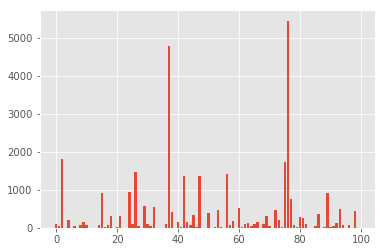

In [99]:

plt.bar( x, y)


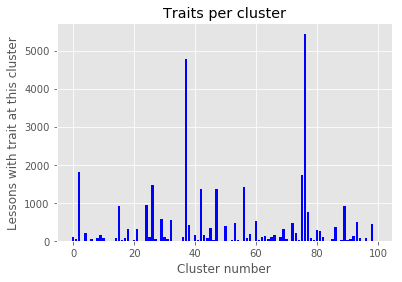

In [100]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Lessons with trait at this cluster')
ax.set_title('Traits per cluster')

